In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [5]:
# Load preprocessed dataset
df = pd.read_csv("bank_preprocessed.csv")

# Ensure all data is numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values (optional)
df.dropna(inplace=True)

# Separate features and target
X = df.drop(columns=['y']).values  # Features
y = df['y'].values  # Target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train_tensor = torch.tensor(y_train).view(-1, 1)  # Reshape for compatibility
y_test_tensor = torch.tensor(y_test).view(-1, 1)

In [7]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [8]:
# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [9]:
# Define the Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [10]:
# Initialize the model
input_dim = X_train.shape[1]
model = LogisticRegression(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
# Lists to store loss and accuracy values for plotting
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
num_epochs = 100

In [12]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    
    # Evaluation on test set
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Accuracy: {test_accuracies[-1]:.2f}%')

Epoch [10/100], Train Loss: 0.2549, Test Loss: 0.2628, Train Accuracy: 89.52%, Test Accuracy: 89.07%
Epoch [20/100], Train Loss: 0.2483, Test Loss: 0.2561, Train Accuracy: 89.83%, Test Accuracy: 89.43%
Epoch [30/100], Train Loss: 0.2448, Test Loss: 0.2525, Train Accuracy: 90.04%, Test Accuracy: 89.65%
Epoch [40/100], Train Loss: 0.2425, Test Loss: 0.2502, Train Accuracy: 90.11%, Test Accuracy: 89.76%
Epoch [50/100], Train Loss: 0.2413, Test Loss: 0.2487, Train Accuracy: 90.16%, Test Accuracy: 89.87%
Epoch [60/100], Train Loss: 0.2403, Test Loss: 0.2476, Train Accuracy: 90.16%, Test Accuracy: 89.91%
Epoch [70/100], Train Loss: 0.2402, Test Loss: 0.2468, Train Accuracy: 90.17%, Test Accuracy: 89.89%
Epoch [80/100], Train Loss: 0.2392, Test Loss: 0.2463, Train Accuracy: 90.17%, Test Accuracy: 89.89%
Epoch [90/100], Train Loss: 0.2388, Test Loss: 0.2459, Train Accuracy: 90.20%, Test Accuracy: 89.86%
Epoch [100/100], Train Loss: 0.2386, Test Loss: 0.2456, Train Accuracy: 90.21%, Test Accura

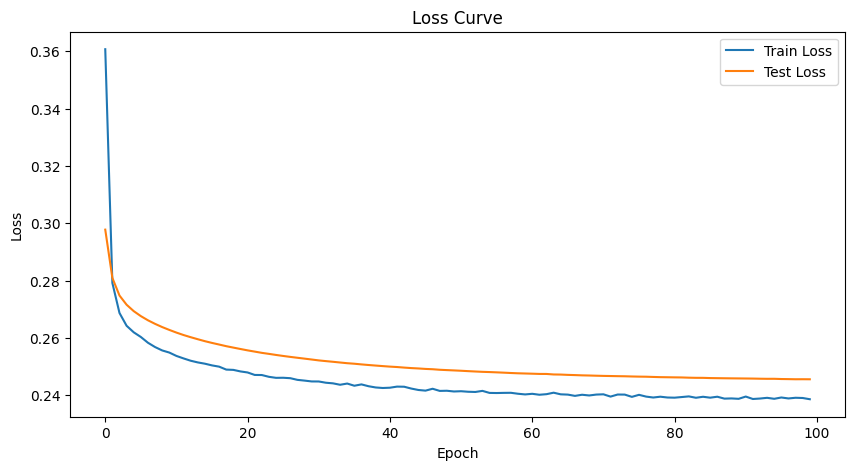

In [13]:
# Plotting the loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

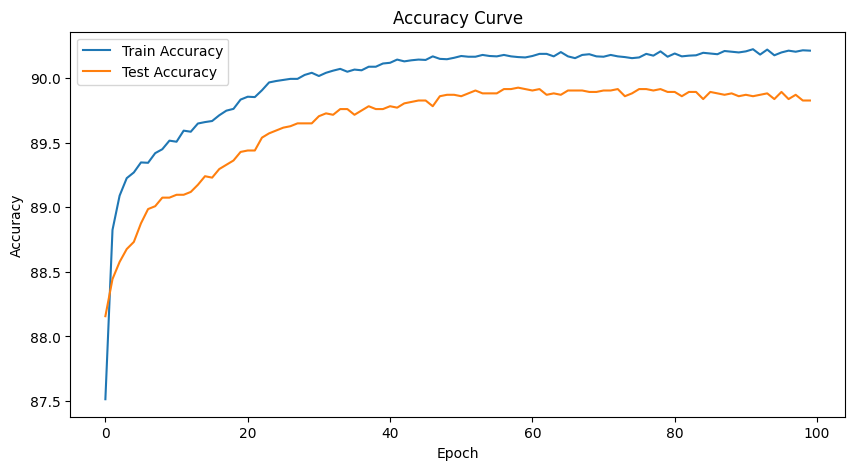

In [14]:
# Plotting the accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

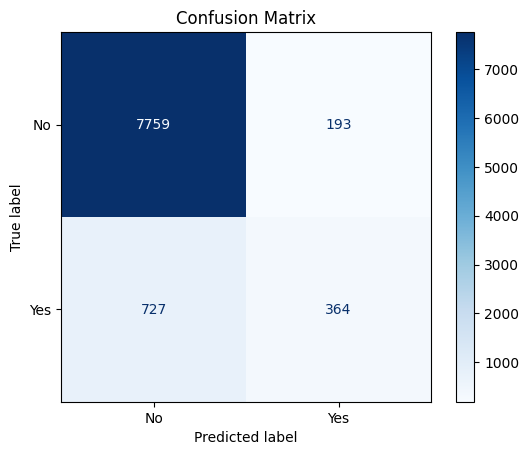

In [15]:
# Confusion Matrix
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()